## Paper Plots

* [Phase Diagram - Chiral Correlation Length](#first-bullet)
* [Phase Diagram - Chiral Susceptibility](#second-bullet)
* [Phase Diagram - Specific Heat](#third-bullet)
* [Enantiomeric Excess Plot](#fourth-bullet)

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d 
import os
from tqdm.auto import tqdm
from numba import jit
import scipy

# loading all of the csv's from all of the simulations with the macro measured data (total energy, ent. excess, Paccept....)
simlist = []
datafiles = []
csvfiles = []
for root, dirs, files in os.walk("../data/400000"):
    for file in files:
        if file.endswith(".npz"):
            datafiles.append(os.path.join(root,file))
        if file.endswith(".csv"):
            csvfiles.append(os.path.join(root,file))
    for name in dirs:
        simlist.append(name)
simlist = sorted(simlist)
datafiles = sorted(datafiles)
csvfiles = sorted(csvfiles)
assert len(simlist) == len(datafiles) == len(csvfiles)


def load_csv(fname,verbose=True):
    if verbose:
        with open(fname) as f:
            print(f.readline().strip('\n'))
    return np.loadtxt(fname,skiprows=1,delimiter=",")

def plot_energy(fpath,csv1,save=False):
    fig,ax1 = plt.subplots()
    ax1.set_title(simlist[0])
    ax1.plot(csv1[:,0],csv1[:,1],label="TotalEnergy")
    ax1.set_xlabel("timesteps")
    ax1.set_ylabel("Total Energy")
    ax1.tick_params(axis ='y', labelcolor="tab:blue")
    ax2  = ax1.twinx()
    ax2.plot(csv1[:,0],csv1[:,2],label="Eexcess",color="tab:orange")
    ax2.set_ylabel("Ent. Excess")
    ax2.tick_params(axis ='y', labelcolor = "tab:orange")
    plt.show()
    if save:
        fname = fpath[:-4]+"_energy.png"
        print(fname)
        fig.savefig(fname)
    
@jit(nopython=True)
def calc_n_corr(nx,ny,nz,nshells):
    g = np.zeros(nshells)
    c = np.zeros(nshells)
    ni,nj,nk = nx.shape
    for i in np.arange(ni):
        for j in np.arange(nj):
            for k in np.arange(nk):
                for di in np.arange(-nshells,nshells+1):
                    for dj in np.arange(-nshells,nshells+1):
                        for dk in np.arange(-nshells,nshells+1):
                            r2 = di*di + dj*dj + dk*dk
                            if r2 < nshells*nshells:
                                rr = np.sqrt(r2)
                                ii = i + di
                                jj = j + dj
                                kk = k + dk
                                if (ii < ni) and (jj < nj) and (kk < nk) and (ii >= 0) and (jj >= 0) and (kk >= 0):
                                    ishell = int(np.floor(rr))
                                    g[ishell] = g[ishell] + (nx[i,j,k]*nx[ii,jj,kk] + ny[i,j,k]*ny[ii,jj,kk] + nz[i,j,k]*nz[ii,jj,kk])**2
                                    c[ishell] += 1
    for ishell in np.arange(nshells):
        g[ishell] = g[ishell]/c[ishell]
    return g,c
                                
@jit(nopython=True)
def calc_s_corr(s,nshells):
    g = np.zeros(nshells)
    c = np.zeros(nshells)
    ni,nj,nk = s.shape
    s_avg2 = np.mean(s)**2
    for i in np.arange(ni):
        for j in np.arange(nj):
            for k in np.arange(nk):
                #print(i,j,k)
                for di in np.arange(-nshells,nshells+1):
                    for dj in np.arange(-nshells,nshells+1):
                        for dk in np.arange(-nshells,nshells+1):
                            r2 = di*di + dj*dj + dk*dk
                            if r2 < nshells*nshells:
                                rr = np.sqrt(r2)
                                ii = i + di
                                jj = j + dj
                                kk = k + dk
                                if (ii < ni) and (jj < nj) and (kk < nk) and (ii >= 0) and (jj >= 0) and (kk >= 0):
                                    ishell = int(np.floor(rr))
                                    #assert ishell > 0
                                    g[ishell] = g[ishell] + s[i,j,k] * s[ii,jj,kk]# - s_avg2
                                    c[ishell] += 1
    for ishell in np.arange(nshells):
        g[ishell] = g[ishell]/c[ishell]# - s_avg2
    return g,c

def plot_s_corr(fpath,g):
    nshells = len(g)
    fig,ax = plt.subplots()
    ax.set_title(fpath.split("/")[-2])
    ax.plot(np.arange(nshells),g)
    ax.set_ylabel("Chiral Correlation")
    ax.set_xlabel("Shells")
    plt.show()

def plot_n_corr(fpath,g):
    nshells = len(g)
    fig,ax = plt.subplots()
    ax.set_title(fpath.split("/")[-2])
    ax.plot(np.arange(nshells),g)
    ax.set_ylabel("Nematic Correlation")
    ax.set_xlabel("Shells")
    plt.show()

def func(x, a, l):
    return a * np.exp(-x/l)
    
def fit_corr_exp(g):
    nshells = len(g)
    popt,pcov = scipy.optimize.curve_fit(func,np.arange(nshells),g)
    return popt[0],popt[1]

def func2(x, a, l, c):
    return a * np.exp(-x/l) + c
    
def fit_corr_exp2(g):
    nshells = len(g)
    popt,pcov = scipy.optimize.curve_fit(func2,np.arange(nshells),g)
    return popt[0],popt[1], popt[2]

def get_temp_K(csvfiles):
    Ks = []
    kbts = []
    for csvfile in csvfiles:
        csv1 = load_csv(csvfile,verbose=False)
        K = float(csvfile.split("/")[3].split("_")[-2][1:])
        kbt = float(csvfile.split("/")[3].split("_")[-1][3:])
        Ks.append(K)
        kbts.append(kbt)#/Tin)
    Ks = sorted(list(set(Ks))) #list of all Ks w/ duplicates removed
    kbts = sorted(list(set(kbts))) # list of all Kbts w/ duplicates removed
    print(Ks)
    print(kbts)
    return kbts,Ks
    
%matplotlib ipympl

default_colormap = 'RdYlBu'#'coolwarm'#'Spectral'#'YlGnBu'
default_fontsize = 24

### Phase diagram plot of chiral correlation length <a name="first-bullet"></a>

[0.0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0, 2.25, 2.5, 2.75, 3.0]
[0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0, 1.05, 1.1, 1.15, 1.2, 1.25, 1.3, 1.35, 1.4, 1.45, 1.5]
default


/tmp/ipykernel_4022/1466926703.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,ax1 = plt.subplots(figsize=(10,10),subplot_kw={"projection": "3d"})


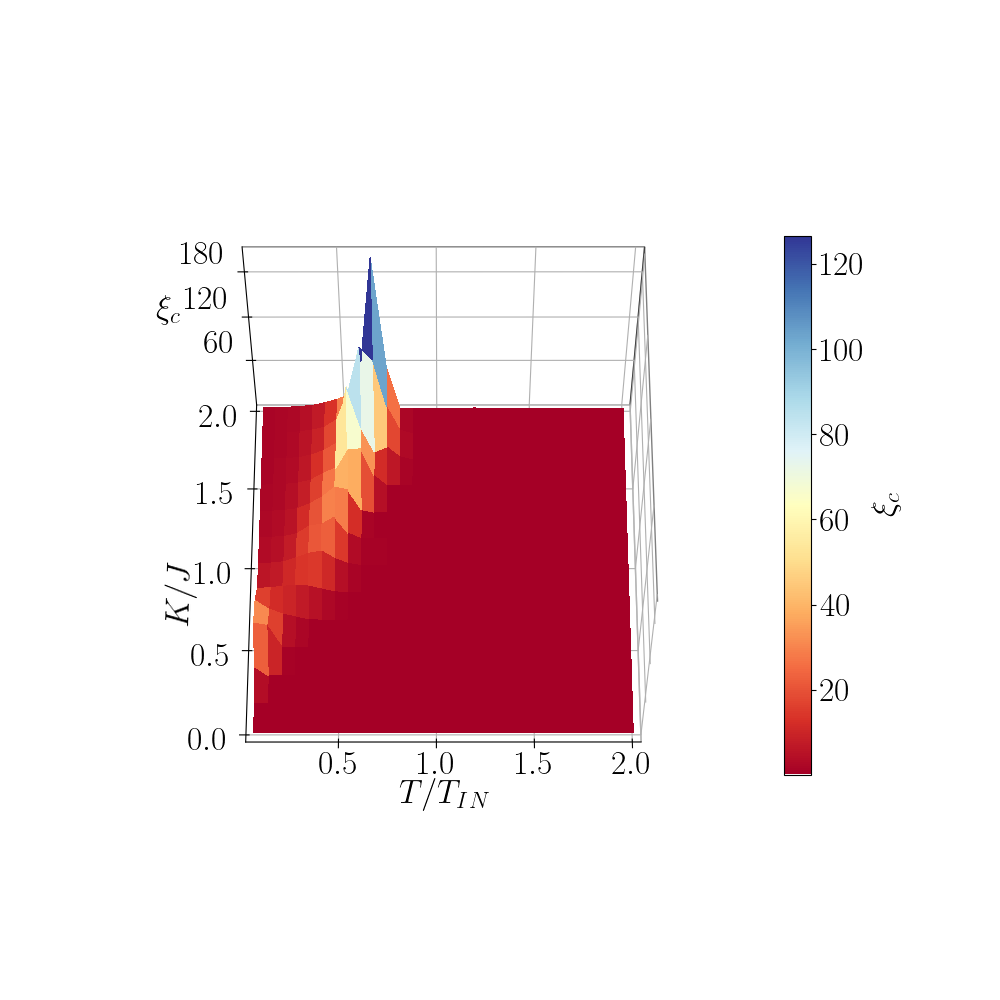

In [33]:
# 3D plot
plt.rcParams['text.usetex'] = True
data = np.load("alignedlong4_ch_l2.npz")
ch_l = data['ch_l']
Tin = 1.1224*(2.0/3.0)
Jinverse = (2.0/3.0)
kbts,Ks = get_temp_K(csvfiles)

kbts = [t/Tin for t in kbts]
Ks = [k*Jinverse for k in Ks] # adjusting these parameters for their corrected values
X,Y = np.meshgrid(kbts,Ks)
fig,ax1 = plt.subplots(figsize=(10,10),subplot_kw={"projection": "3d"})
ax1.set_ylabel(r'$ K/J $',labelpad=24,fontsize=default_fontsize)
ax1.set_xlabel(r'$ T/T_{IN} $',fontsize=default_fontsize)
ax1.set_xlim(np.min(kbts),np.max(kbts))
ax1.set_ylim(np.min(Ks),np.max(Ks))
#ax1.set_zlim(0,25)
#ax1.set_zlabel(r'$ \chi_c $',fontsize=16,labelpad=-26)
ax1.zaxis.set_rotate_label(False)
print(ax1.zaxis.get_label_position())
ax1.zaxis.set_label_position("upper")
ax1.zaxis.set_label_coords(1.0,0.5)

ax1.view_init(60, -90.01,0) # note -90.01 gets the axes on left side
ax1.xaxis.pane.set_edgecolor('black')
ax1.yaxis.pane.set_edgecolor('black')
ax1.xaxis.pane.fill = False
ax1.yaxis.pane.fill = False
ax1.zaxis.pane.fill = False
surf1 = ax1.plot_surface(X, Y, ch_l.T, cmap=default_colormap,linewidth=1, antialiased=False)
#surf1 = ax1.plot_wireframe(X, Y, ch_sus.T, cmap='viridis',linewidth=0.5, antialiased=False)
cbar1 = plt.colorbar(surf1, ax=ax1,shrink=0.7)
cbar1.set_label(r'$ \xi_c $',fontsize=default_fontsize, rotation=90)
cbar1.ax.tick_params(labelsize=default_fontsize)

[t.set_va('center') for t in ax1.get_yticklabels()]
[t.set_ha('right') for t in ax1.get_yticklabels()]
[t.set_va('center') for t in ax1.get_xticklabels()]
[t.set_ha('center') for t in ax1.get_xticklabels()]
[t.set_va('center') for t in ax1.get_zticklabels()]
[t.set_ha('right') for t in ax1.get_zticklabels()]
ax1.xaxis.set_tick_params(labelsize=default_fontsize)
ax1.yaxis.set_tick_params(labelsize=default_fontsize)
ax1.zaxis.set_tick_params(labelsize=default_fontsize)

ax1.xaxis.set_major_locator(plt.MaxNLocator(4))
ax1.yaxis.set_major_locator(plt.MaxNLocator(4))
ax1.zaxis.set_major_locator(plt.MaxNLocator(4))

# ax1.text2D(0.175, 0.95,r'$ \chi_c $', 
#           transform=ax1.transAxes, fontsize=16)
ax1.text2D(0.05, 0.8,r'$ \xi_c $', 
          transform=ax1.transAxes, fontsize=default_fontsize)
fig.align_labels()
plt.show()

[0.0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0, 2.25, 2.5, 2.75, 3.0]
[0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0, 1.05, 1.1, 1.15, 1.2, 1.25, 1.3, 1.35, 1.4, 1.45, 1.5]


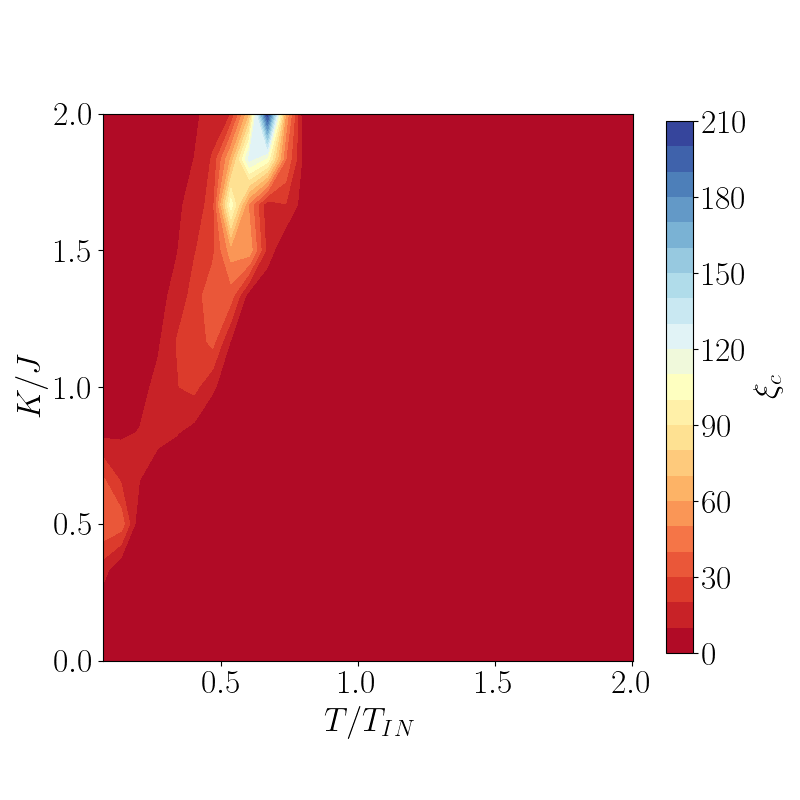

In [35]:
plt.rcParams['text.usetex'] = True
data = np.load("alignedlong4_ch_l2.npz")
ch_l = data['ch_l']
Tin = 1.1224*(2.0/3.0)
Jinverse = (2.0/3.0)
kbts,Ks = get_temp_K(csvfiles)

kbts = [t/Tin for t in kbts]
Ks = [k*Jinverse for k in Ks] # adjusting these parameters for their corrected values
X,Y = np.meshgrid(kbts,Ks)
fig,ax1 = plt.subplots(figsize=(8,8))
ax1.set_ylabel(r'\textbf{$ K/J $}',fontsize=default_fontsize)
ax1.set_xlabel(r'\textbf{$ T/T_{IN} $}',fontsize=default_fontsize)
ax1.set_xlim(np.min(kbts),np.max(kbts))
ax1.set_ylim(np.min(Ks),np.max(Ks))
#ax1.set_zlim(0,64)
#ax1.set_zlabel(r'$ \chi_c $')
cont1 = ax1.contourf(X, Y, ch_l.T, cmap=default_colormap,levels=default_fontsize) #BuPu
#cont1 = ax1.contour(X, Y, ch_sus, cmap='viridis',levels=16)
cbar1 = plt.colorbar(cont1, ax=ax1,spacing="uniform",shrink=0.715)
cbar1.set_label(r'\textbf{$ \xi_c $}', rotation=90,fontsize=default_fontsize)
cbar1.ax.tick_params(labelsize=default_fontsize)
plt.xticks(fontsize=default_fontsize)
plt.yticks(fontsize=default_fontsize)
ax1.xaxis.set_major_locator(plt.MaxNLocator(4))
ax1.yaxis.set_major_locator(plt.MaxNLocator(4))
ax1.set_aspect(1)
fig.tight_layout()
plt.show()

[0.0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0, 2.25, 2.5, 2.75, 3.0]
[0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0, 1.05, 1.1, 1.15, 1.2, 1.25, 1.3, 1.35, 1.4, 1.45, 1.5]


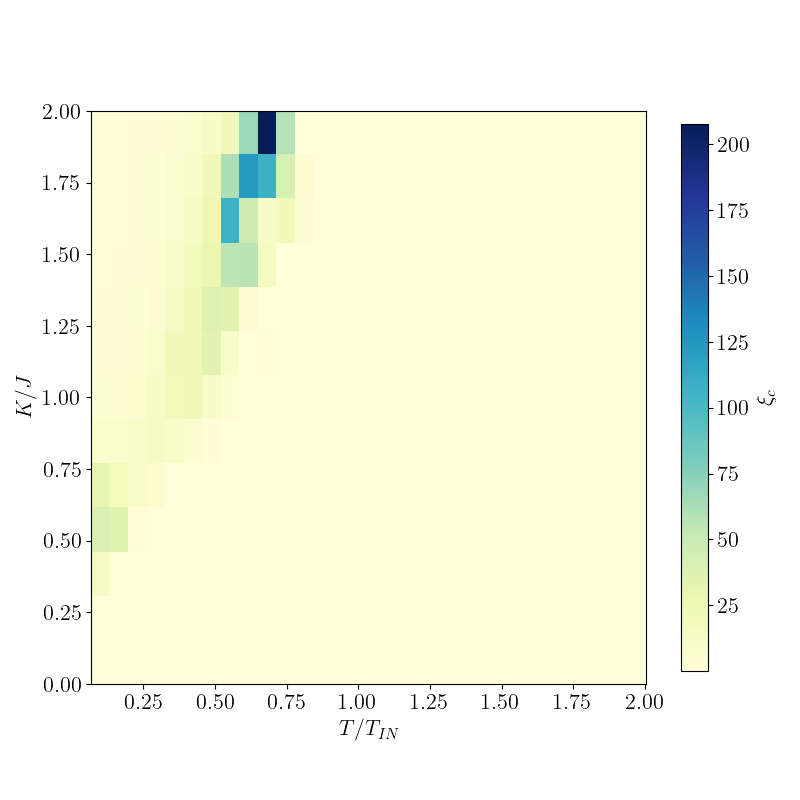

In [10]:
plt.rcParams['text.usetex'] = True
data = np.load("alignedlong4_ch_l2.npz")
ch_l = data['ch_l']
Tin = 1.1224*(2.0/3.0)
Jinverse = (2.0/3.0)
kbts,Ks = get_temp_K(csvfiles)

kbts = [t/Tin for t in kbts]
Ks = [k*Jinverse for k in Ks] # adjusting these parameters for their corrected values
X,Y = np.meshgrid(kbts,Ks)
fig,ax1 = plt.subplots(figsize=(8,8))
ax1.set_ylabel(r'\textbf{$ K/J $}',fontsize=default_fontsize)
ax1.set_xlabel(r'\textbf{$ T/T_{IN} $}',fontsize=default_fontsize)
ax1.set_xlim(np.min(kbts),np.max(kbts))
ax1.set_ylim(np.min(Ks),np.max(Ks))
#ax1.set_zlim(0,64)
#ax1.set_zlabel(r'$ \chi_c $')
cont1 = ax1.imshow(ch_l.T, cmap=default_colormap,origin="lower",extent = (np.min(kbts),np.max(kbts),np.min(Ks),np.max(Ks)),interpolation="antialiased") #BuPu
#cont1 = ax1.contour(X, Y, ch_sus, cmap='viridis',levels=16)
cbar1 = plt.colorbar(cont1, ax=ax1,spacing="uniform",shrink=0.715)
cbar1.set_label(r'\textbf{$ \xi_c $}', rotation=90,fontsize=default_fontsize)
cbar1.ax.tick_params(labelsize=default_fontsize)
plt.xticks(fontsize=default_fontsize)
plt.yticks(fontsize=default_fontsize)
ax1.set_aspect(1)
fig.tight_layout()
plt.show()

### Phase diagram plot of chiral susceptibility <a name="second-bullet"></a>

In [38]:
# loading all of the csv's from all of the simulations with the macro measured data (total energy, ent. excess, Paccept....)
simlist = []
datafiles = []
csvfiles = []
for root, dirs, files in os.walk("../data/400000"):
    for file in files:
        if file.endswith(".npz"):
            datafiles.append(os.path.join(root,file))
        if file.endswith(".csv"):
            csvfiles.append(os.path.join(root,file))
    for name in dirs:
        simlist.append(name)
simlist = sorted(simlist)
datafiles = sorted(datafiles)
csvfiles = sorted(csvfiles)
assert len(simlist) == len(datafiles) == len(csvfiles)

In [39]:
# THIS TAKES A LONG TIME TO RUN
kbts,Ks = get_temp_K(csvfiles)
ch_sus = np.zeros((len(Ks),len(kbts)))
print(ch_sus.shape)
N3 = 64**3
for i,Kplot in enumerate(Ks):
    for j,Tplot in enumerate(kbts):
        for csvfile in csvfiles:
            csv1 = load_csv(csvfile,verbose=False)
            K = float(csvfile.split("/")[3].split("_")[-2][1:])
            kbt = float(csvfile.split("/")[3].split("_")[-1][3:])
            #print("G ",g,gPlot)
            if K == Kplot and kbt == Tplot and "alignedlong4" in csvfile:
                excess = csv1[7500:,2]
                ch_sus[i,j] = (np.mean(excess**2) - np.mean(excess)**2)/(kbt*N3**2)

np.savez_compressed("alignedlong4_ch_sus.npz",ch_sus=ch_sus)

[0.0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0, 2.25, 2.5, 2.75, 3.0]
[0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0, 1.05, 1.1, 1.15, 1.2, 1.25, 1.3, 1.35, 1.4, 1.45, 1.5]
(13, 30)


KeyboardInterrupt: 

[0.0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0, 2.25, 2.5, 2.75, 3.0]
[0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0, 1.05, 1.1, 1.15, 1.2, 1.25, 1.3, 1.35, 1.4, 1.45, 1.5]
default


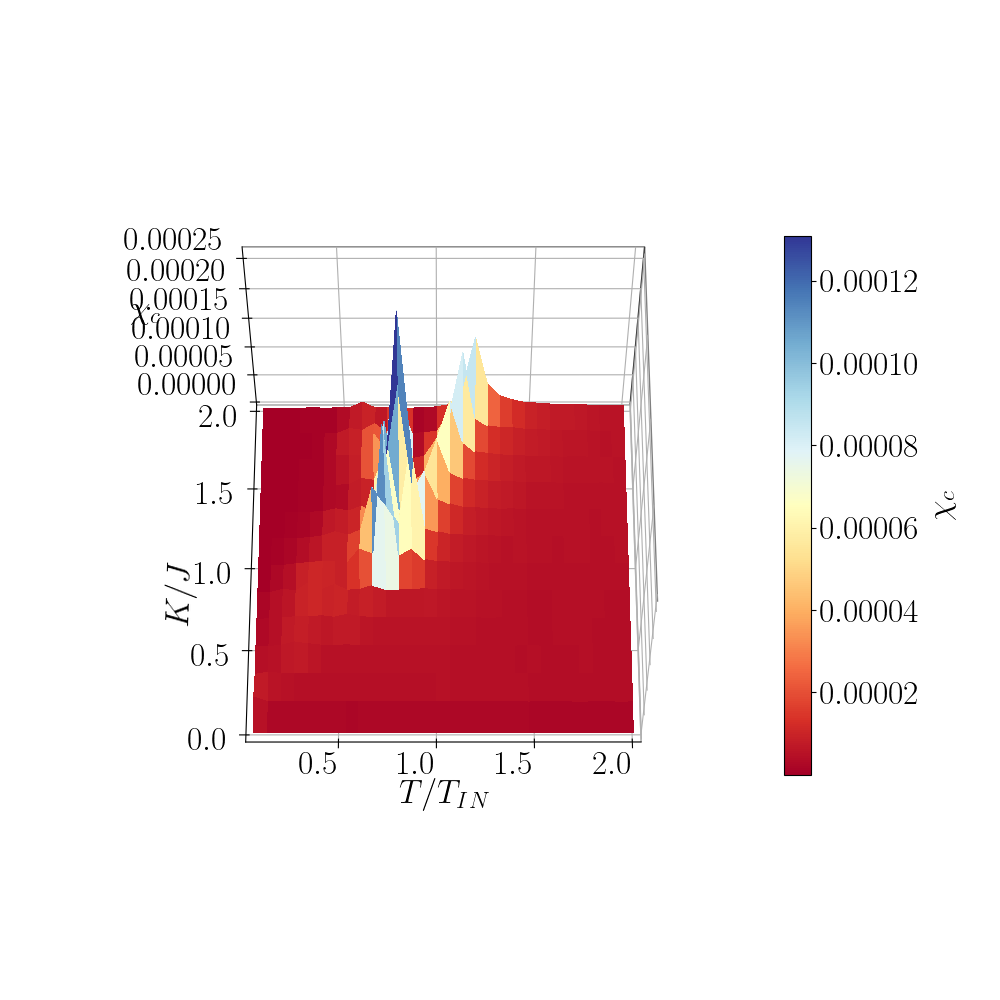

In [36]:
# 3D plot
plt.rcParams['text.usetex'] = True
data = np.load("alignedlong4_ch_sus.npz")
ch_sus = data['ch_sus']
Tin = 1.1224*(2.0/3.0)
Jinverse = (2.0/3.0)
kbts,Ks = get_temp_K(csvfiles)

kbts = [t/Tin for t in kbts]
Ks = [k*Jinverse for k in Ks] # adjusting these parameters for their corrected values
X,Y = np.meshgrid(kbts,Ks)
fig,ax1 = plt.subplots(figsize=(10,10),subplot_kw={"projection": "3d"})
ax1.set_ylabel(r'$ K/J $',labelpad=24,fontsize=default_fontsize)
ax1.set_xlabel(r'$ T/T_{IN} $',fontsize=default_fontsize)
ax1.set_xlim(np.min(kbts),np.max(kbts))
ax1.set_ylim(np.min(Ks),np.max(Ks))
#ax1.set_zlim(0,64)
#ax1.set_zlabel(r'$ \chi_c $',fontsize=16,labelpad=-26)
ax1.zaxis.set_rotate_label(False)
print(ax1.zaxis.get_label_position())
ax1.zaxis.set_label_position("upper")
ax1.zaxis.set_label_coords(1.0,0.5)

ax1.view_init(60, -90.01,0) # note -90.01 gets the axes on left side
ax1.xaxis.pane.set_edgecolor('black')
ax1.yaxis.pane.set_edgecolor('black')
ax1.xaxis.pane.fill = False
ax1.yaxis.pane.fill = False
ax1.zaxis.pane.fill = False
surf1 = ax1.plot_surface(X, Y, ch_sus, cmap=default_colormap,linewidth=1, antialiased=False)
#surf1 = ax1.plot_wireframe(X, Y, ch_sus.T, cmap='viridis',linewidth=0.5, antialiased=False)
cbar1 = plt.colorbar(surf1, ax=ax1,shrink=0.7)
cbar1.set_label(r'$ \chi_c $',fontsize=default_fontsize, rotation=90)
cbar1.ax.tick_params(labelsize=default_fontsize)

[t.set_va('center') for t in ax1.get_yticklabels()]
[t.set_ha('right') for t in ax1.get_yticklabels()]
[t.set_va('center') for t in ax1.get_xticklabels()]
[t.set_ha('right') for t in ax1.get_xticklabels()]
[t.set_va('center') for t in ax1.get_zticklabels()]
[t.set_ha('right') for t in ax1.get_zticklabels()]
ax1.xaxis.set_tick_params(labelsize=default_fontsize)
ax1.yaxis.set_tick_params(labelsize=default_fontsize)
ax1.zaxis.set_tick_params(labelsize=default_fontsize)

# ax1.text2D(0.175, 0.95,r'$ \chi_c $', 
#           transform=ax1.transAxes, fontsize=16)
ax1.text2D(0.01, 0.8,r'$ \chi_c $', 
          transform=ax1.transAxes, fontsize=default_fontsize)
fig.align_labels()
plt.show()

[0.0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0, 2.25, 2.5, 2.75, 3.0]
[0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0, 1.05, 1.1, 1.15, 1.2, 1.25, 1.3, 1.35, 1.4, 1.45, 1.5]


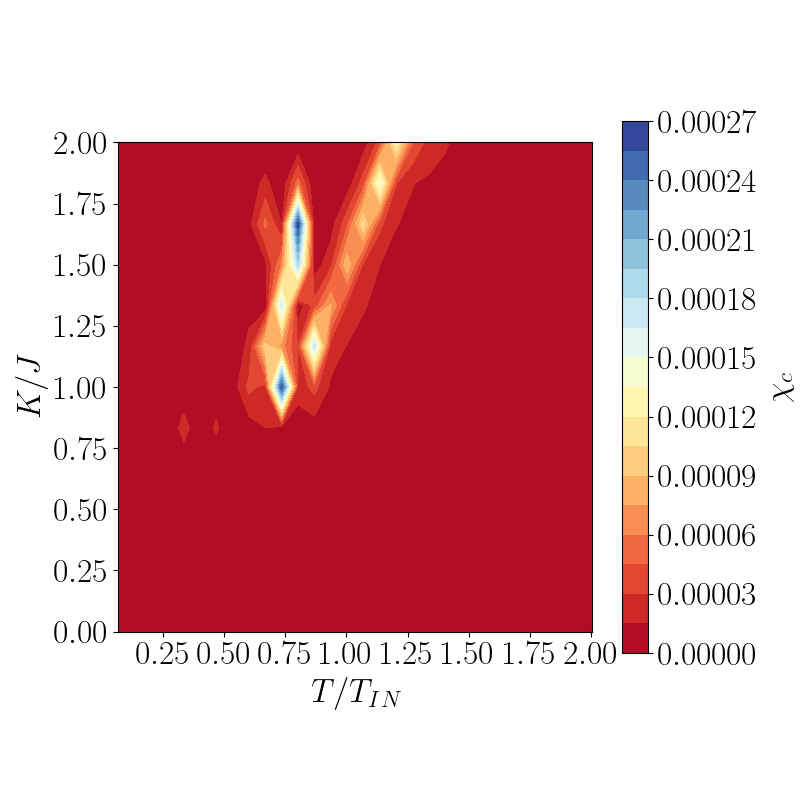

In [37]:
plt.rcParams['text.usetex'] = True
data = np.load("alignedlong4_ch_sus.npz")
ch_sus = data['ch_sus']
Tin = 1.1224*(2.0/3.0)
Jinverse = (2.0/3.0)
kbts,Ks = get_temp_K(csvfiles)

kbts = [t/Tin for t in kbts]
Ks = [k*Jinverse for k in Ks] # adjusting these parameters for their corrected values
X,Y = np.meshgrid(kbts,Ks)
fig,ax1 = plt.subplots(figsize=(8,8))
ax1.set_ylabel(r'\textbf{$ K/J $}',fontsize=default_fontsize)
ax1.set_xlabel(r'\textbf{$ T/T_{IN} $}',fontsize=default_fontsize)
ax1.set_xlim(np.min(kbts),np.max(kbts))
ax1.set_ylim(np.min(Ks),np.max(Ks))
#ax1.set_zlim(0,64)
#ax1.set_zlabel(r'$ \chi_c $')
cont1 = ax1.contourf(X, Y, ch_sus, cmap=default_colormap,levels=default_fontsize) #BuPu
#cont1 = ax1.contour(X, Y, ch_sus, cmap='viridis',levels=16)
cbar1 = plt.colorbar(cont1, ax=ax1,spacing="uniform",shrink=0.715)
cbar1.set_label(r'\textbf{$ \chi_c $}', rotation=90,fontsize=default_fontsize)
cbar1.ax.tick_params(labelsize=default_fontsize)
plt.xticks(fontsize=default_fontsize)
plt.yticks(fontsize=default_fontsize)
ax1.set_aspect(1)
fig.tight_layout()
plt.show()

[0.0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0, 2.25, 2.5, 2.75, 3.0]
[0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0, 1.05, 1.1, 1.15, 1.2, 1.25, 1.3, 1.35, 1.4, 1.45, 1.5]


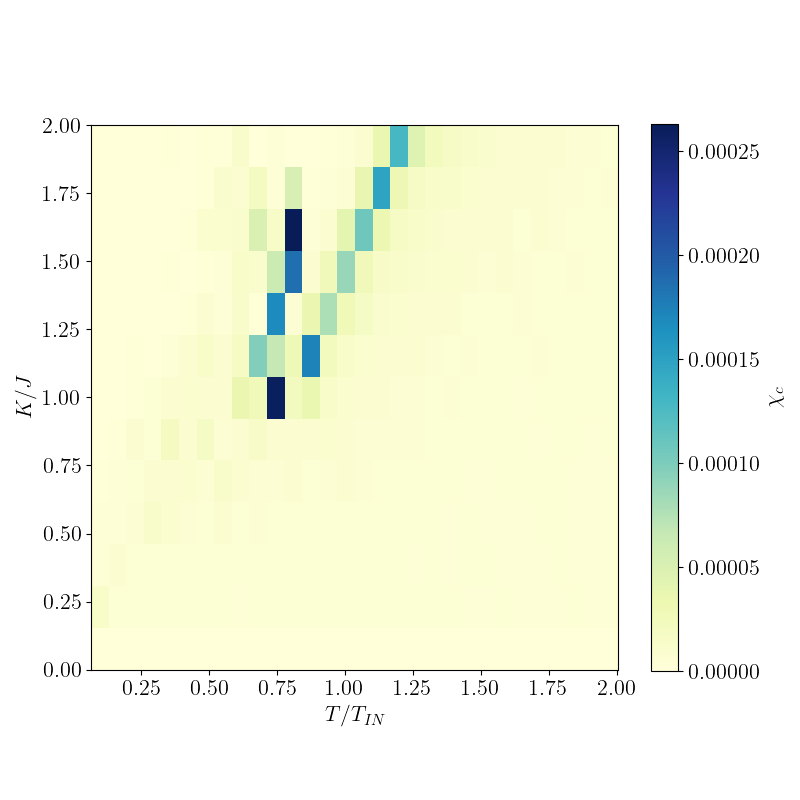

In [13]:
plt.rcParams['text.usetex'] = True
data = np.load("alignedlong4_ch_sus.npz")
ch_sus = data['ch_sus']
Tin = 1.1224*(2.0/3.0)
Jinverse = (2.0/3.0)
kbts,Ks = get_temp_K(csvfiles)

kbts = [t/Tin for t in kbts]
Ks = [k*Jinverse for k in Ks] # adjusting these parameters for their corrected values
X,Y = np.meshgrid(kbts,Ks)
fig,ax1 = plt.subplots(figsize=(8,8))
ax1.set_ylabel(r'\textbf{$ K/J $}',fontsize=default_fontsize)
ax1.set_xlabel(r'\textbf{$ T/T_{IN} $}',fontsize=default_fontsize)
ax1.set_xlim(np.min(kbts),np.max(kbts))
ax1.set_ylim(np.min(Ks),np.max(Ks))
#ax1.set_zlim(0,64)
#ax1.set_zlabel(r'$ \chi_c $')
cont1 = ax1.imshow(ch_sus, cmap=default_colormap,origin="lower",extent = (np.min(kbts),np.max(kbts),np.min(Ks),np.max(Ks)),interpolation="antialiased") #BuPu
#cont1 = ax1.contour(X, Y, ch_sus, cmap='viridis',levels=16)
cbar1 = plt.colorbar(cont1, ax=ax1,spacing="uniform",shrink=0.715)
cbar1.set_label(r'\textbf{$ \chi_c $}', rotation=90,fontsize=default_fontsize)
cbar1.ax.tick_params(labelsize=default_fontsize)
plt.xticks(fontsize=default_fontsize)
plt.yticks(fontsize=default_fontsize)
ax1.set_aspect(1)
fig.tight_layout()
plt.show()

### Phase diagram plot of specific heat <a name="third-bullet"></a>

In [5]:
# 3d chiral susceptibility
# get all Ks and kbts for a range
# loading all of the csv's from all of the simulations with the macro measured data (total energy, ent. excess, Paccept....)
simlist = []
datafiles = []
csvfiles = []
for root, dirs, files in os.walk("../data/400000"):
    for file in files:
        if file.endswith(".npz"):
            datafiles.append(os.path.join(root,file))
        if file.endswith(".csv"):
            csvfiles.append(os.path.join(root,file))
    for name in dirs:
        simlist.append(name)
simlist = sorted(simlist)
datafiles = sorted(datafiles)
csvfiles = sorted(csvfiles)
assert len(simlist) == len(datafiles) == len(csvfiles)


Ks = []
kbts = []
for csvfile in csvfiles:
    csv1 = load_csv(csvfile,verbose=False)
    K = float(csvfile.split("/")[3].split("_")[-2][1:])
    kbt = float(csvfile.split("/")[3].split("_")[-1][3:])
    Ks.append(K)
    kbts.append(kbt)
    
Ks = sorted(list(set(Ks))) #list of all Ks w/ duplicates removed
# Ks1 = Ks[:10] # 0.001 -> 0.01
# Ks2 = Ks[9:19] # 0.01 -> 0.1
# Ks3 = Ks[18:] # 0.1 -> 1.0
kbts = sorted(list(set(kbts))) # list of all Kbts w/ duplicates removed
print(Ks)
print(kbts)
#assert len(Ks1) == len(Ks2) == len(Ks3)

C_v = np.empty((len(kbts),len(Ks)))
print(C_v.shape)
for csvfile in csvfiles:
    csv1 = load_csv(csvfile,verbose=False)
    K = float(csvfile.split("/")[3].split("_")[-2][1:])
    kbt = float(csvfile.split("/")[3].split("_")[-1][3:])
    if K in Ks and "alignedlong4" in csvfile:
        K_index = Ks.index(K)
        kbt_index = kbts.index(kbt)
        #specific heat
        E = csv1[7500:,1]
        C_v[kbt_index,K_index] = (np.mean(E**2) - np.mean(E)**2)/kbt

[0.0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0, 2.25, 2.5, 2.75, 3.0]
[0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0, 1.05, 1.1, 1.15, 1.2, 1.25, 1.3, 1.35, 1.4, 1.45, 1.5]
(30, 13)


[0.0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0, 2.25, 2.5, 2.75, 3.0]
[0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0, 1.05, 1.1, 1.15, 1.2, 1.25, 1.3, 1.35, 1.4, 1.45, 1.5]


/tmp/ipykernel_4022/1077755215.py:54: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()


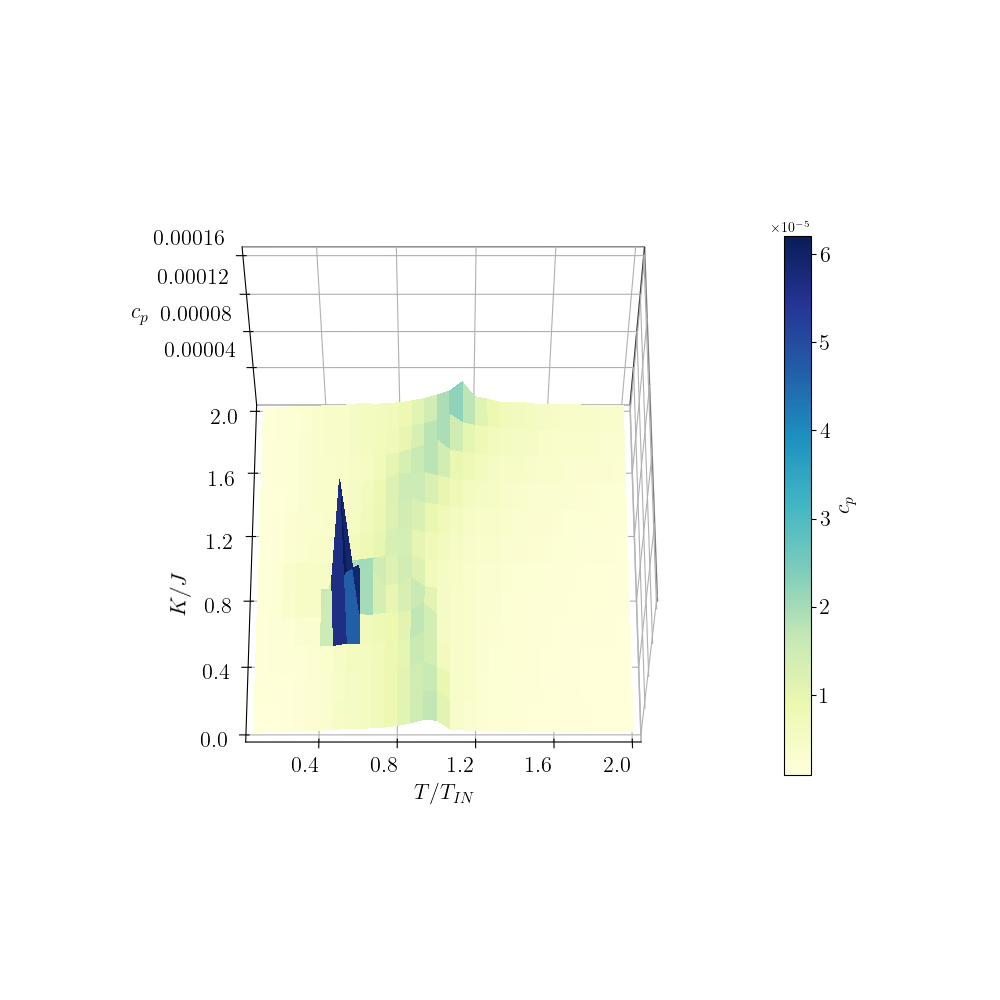

In [7]:
# 3D plot
plt.rcParams['text.usetex'] = True
Tin = 1.1224*(2.0/3.0)
Jinverse = (2.0/3.0)
kbts,Ks = get_temp_K(csvfiles)

kbts = [t/Tin for t in kbts]
Ks = [k*Jinverse for k in Ks] # adjusting these parameters for their corrected values
X,Y = np.meshgrid(kbts,Ks)
fig,ax1 = plt.subplots(figsize=(10,10),subplot_kw={"projection": "3d"})
ax1.set_ylabel(r'$ K/J $',labelpad=24,fontsize=default_fontsize)
ax1.set_xlabel(r'$ T/T_{IN} $',fontsize=default_fontsize)
ax1.set_xlim(np.min(kbts),np.max(kbts))
ax1.set_ylim(np.min(Ks),np.max(Ks))
#ax1.set_zlim(0,64)
#ax1.set_zlabel(r'$ \chi_c $',fontsize=16,labelpad=-26)
ax1.zaxis.set_rotate_label(False)
#print(ax1.zaxis.get_label_position())
#ax1.zaxis.set_label_position("upper")
#ax1.zaxis.set_label_coords(1.0,0.5)

ax1.view_init(60, -90.01,0) # note -90.01 gets the axes on left side
#ax1.view_init(20, -90.01,0) # note -90.01 gets the axes on left side

ax1.xaxis.pane.set_edgecolor('black')
ax1.yaxis.pane.set_edgecolor('black')
ax1.xaxis.pane.fill = False
ax1.yaxis.pane.fill = False
ax1.zaxis.pane.fill = False
surf1 = ax1.plot_surface(X, Y, C_v.T, cmap=default_colormap,linewidth=1, antialiased=False)
#surf1 = ax1.plot_wireframe(X, Y, ch_sus.T, cmap='viridis',linewidth=0.5, antialiased=False)
cbar1 = plt.colorbar(surf1, ax=ax1,shrink=0.7)
cbar1.set_label(r'$ c_p $',fontsize=default_fontsize, rotation=90)
cbar1.ax.tick_params(labelsize=default_fontsize)

[t.set_va('center') for t in ax1.get_yticklabels()]
[t.set_ha('right') for t in ax1.get_yticklabels()]
[t.set_va('center') for t in ax1.get_xticklabels()]
[t.set_ha('right') for t in ax1.get_xticklabels()]
[t.set_va('center') for t in ax1.get_zticklabels()]
[t.set_ha('right') for t in ax1.get_zticklabels()]
ax1.xaxis.set_tick_params(labelsize=default_fontsize)
ax1.yaxis.set_tick_params(labelsize=default_fontsize)
ax1.zaxis.set_tick_params(labelsize=default_fontsize)
ax1.xaxis.set_major_locator(plt.MaxNLocator(5))
ax1.yaxis.set_major_locator(plt.MaxNLocator(5))
ax1.zaxis.set_major_locator(plt.MaxNLocator(5))

# ax1.text2D(0.175, 0.95,r'$ \chi_c $', 
#           transform=ax1.transAxes, fontsize=16)
ax1.text2D(0.01, 0.8,r'$ c_p $', 
          transform=ax1.transAxes, fontsize=default_fontsize)
fig.align_labels()
fig.tight_layout()
plt.show()

[0.0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0, 2.25, 2.5, 2.75, 3.0]
[0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0, 1.05, 1.1, 1.15, 1.2, 1.25, 1.3, 1.35, 1.4, 1.45, 1.5]


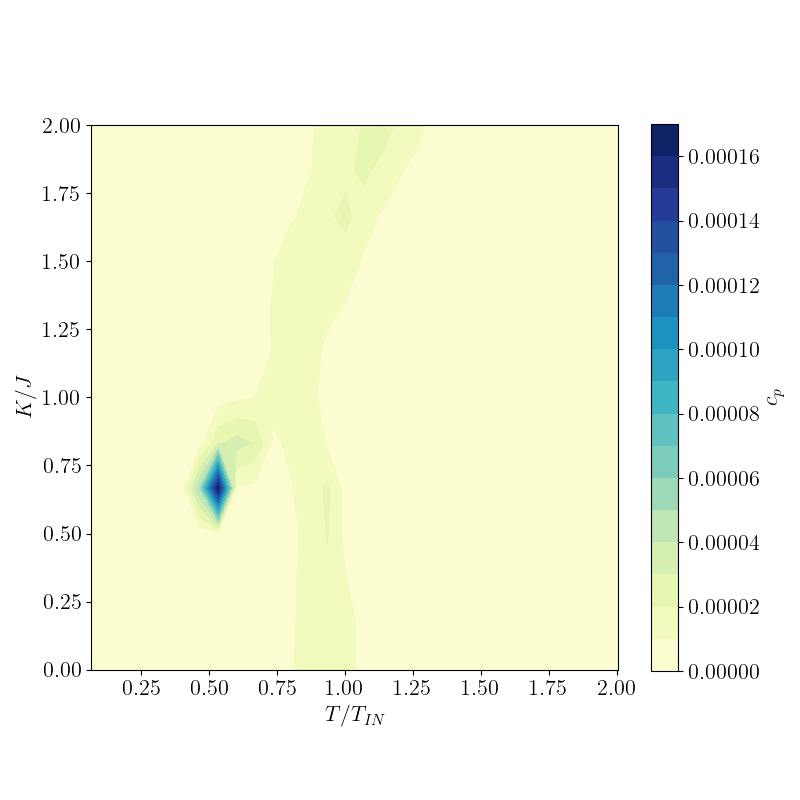

In [26]:
plt.rcParams['text.usetex'] = True
Tin = 1.1224*(2.0/3.0)
Jinverse = (2.0/3.0)
kbts,Ks = get_temp_K(csvfiles)

kbts = [t/Tin for t in kbts]
Ks = [k*Jinverse for k in Ks] # adjusting these parameters for their corrected values
X,Y = np.meshgrid(kbts,Ks)
fig,ax1 = plt.subplots(figsize=(8,8))
ax1.set_ylabel(r'\textbf{$ K/J $}',fontsize=default_fontsize)
ax1.set_xlabel(r'\textbf{$ T/T_{IN} $}',fontsize=default_fontsize)
ax1.set_xlim(np.min(kbts),np.max(kbts))
ax1.set_ylim(np.min(Ks),np.max(Ks))
#ax1.set_zlim(0,64)
#ax1.set_zlabel(r'$ \chi_c $')
cont1 = ax1.contourf(X, Y, C_v.T, cmap=default_colormap,levels=default_fontsize) #BuPu
#cont1 = ax1.contour(X, Y, ch_sus, cmap='viridis',levels=16)
cbar1 = plt.colorbar(cont1, ax=ax1,spacing="uniform",shrink=0.715)
cbar1.set_label(r'\textbf{$ c_p $}', rotation=90,fontsize=default_fontsize)
cbar1.ax.tick_params(labelsize=default_fontsize)
plt.xticks(fontsize=default_fontsize)
plt.yticks(fontsize=default_fontsize)
ax1.set_aspect(1)
fig.tight_layout()
plt.show()

[0.0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0, 2.25, 2.5, 2.75, 3.0]
[0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0, 1.05, 1.1, 1.15, 1.2, 1.25, 1.3, 1.35, 1.4, 1.45, 1.5]


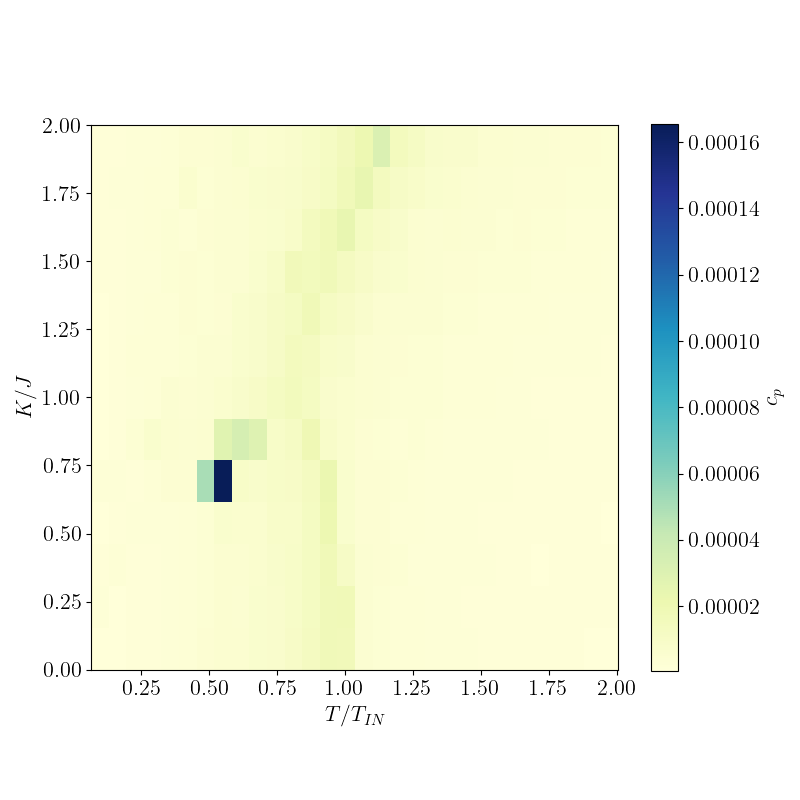

In [27]:
plt.rcParams['text.usetex'] = True
Tin = 1.1224*(2.0/3.0)
Jinverse = (2.0/3.0)
kbts,Ks = get_temp_K(csvfiles)

kbts = [t/Tin for t in kbts]
Ks = [k*Jinverse for k in Ks] # adjusting these parameters for their corrected values
X,Y = np.meshgrid(kbts,Ks)
fig,ax1 = plt.subplots(figsize=(8,8))
ax1.set_ylabel(r'\textbf{$ K/J $}',fontsize=default_fontsize)
ax1.set_xlabel(r'\textbf{$ T/T_{IN} $}',fontsize=default_fontsize)
ax1.set_xlim(np.min(kbts),np.max(kbts))
ax1.set_ylim(np.min(Ks),np.max(Ks))
#ax1.set_zlim(0,64)
#ax1.set_zlabel(r'$ \chi_c $')
cont1 = ax1.imshow(C_v.T, cmap=default_colormap,origin="lower",extent = (np.min(kbts),np.max(kbts),np.min(Ks),np.max(Ks)),interpolation="antialiased") #BuPu
#cont1 = ax1.contour(X, Y, ch_sus, cmap='viridis',levels=16)
cbar1 = plt.colorbar(cont1, ax=ax1,spacing="uniform",shrink=0.715)
cbar1.set_label(r'\textbf{$ c_p $}', rotation=90,fontsize=default_fontsize)
cbar1.ax.tick_params(labelsize=default_fontsize)
plt.xticks(fontsize=default_fontsize)
plt.yticks(fontsize=default_fontsize)
ax1.set_aspect(1)
fig.tight_layout()
plt.show()

### Enantiomeric Excess Plot <a name="fourth-bullet"></a>

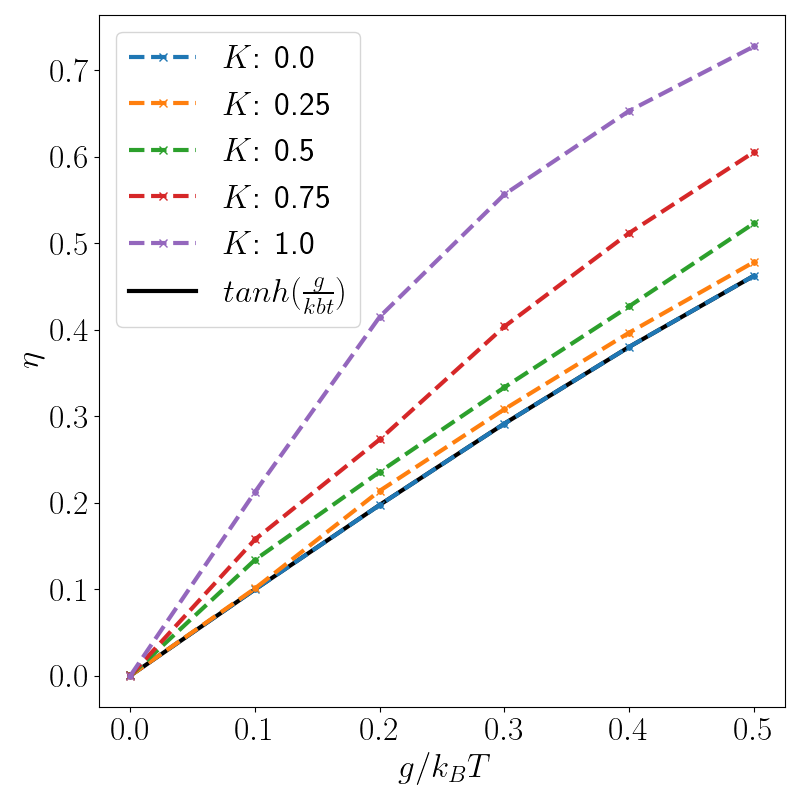

In [60]:
# loading all of the csv's from all of the simulations with the macro measured data (total energy, ent. excess, Paccept....)
simlist = []
datafiles = []
csvfiles = []
for root, dirs, files in os.walk("../data/gfield2"):
    for file in files:
        if file.endswith(".npz"):
            datafiles.append(os.path.join(root,file))
        if file.endswith(".csv"):
            csvfiles.append(os.path.join(root,file))
    for name in dirs:
        simlist.append(name)
simlist = sorted(simlist)
datafiles = sorted(datafiles)
csvfiles = sorted(csvfiles)
assert len(simlist) == len(datafiles) == len(csvfiles)
plt.rcParams['text.usetex'] = True
    
def g_plot(Tplot):
    Tplot = np.around(Tplot,2)
    init_type="gfield2"
    fig,ax = plt.subplots(1,1,figsize=(8,8))
    for Kplot in np.arange(0.0,1.1,0.25):
        X,Y = [],[]
        for gPlot in np.arange(0.0,0.251,0.05):
            for csvfile in csvfiles:
                csv1 = load_csv(csvfile,verbose=False)
                K = float(csvfile.split("/")[3].split("_")[-3][1:])
                kbt = float(csvfile.split("/")[3].split("_")[-2][3:])
                g = float(csvfile.split("/")[3].split("_")[-1][1:])
                #print("G ",g,gPlot)
                if K == Kplot and kbt == Tplot and g == np.around(gPlot,2) and init_type in csvfile:
                    #print(K,g,kbt,g/kbt)
                    X.append(g/kbt)
                    Y.append(np.abs(np.mean(csv1[7500:,2])))
        zipped = list(zip(X,Y))
        zipped.sort()
        X,Y = zip(*zipped)
        ax.scatter(X,Y,marker='x',linewidth=3,zorder=2)
        #ax.set_title("kbt="+str(Tplot))
        ax.plot(X,Y,marker='x',linewidth=3,linestyle='dashed',label=r"\textbf{$K$}: "+str(np.around(Kplot,3)),zorder=2)
        ax.set_ylabel(r'\textbf{ $\eta$}',fontsize=default_fontsize)
        ax.set_xlabel(r'\textbf{$g/k_B T$}',fontsize=default_fontsize)

    ax.plot(X,np.tanh(X),linewidth=3,linestyle='solid',label=r"$tanh(\frac{g}{kbt})$",color='k',zorder=1)
    plt.xticks(fontsize=default_fontsize)
    plt.yticks(fontsize=default_fontsize)
    plt.legend(fontsize=default_fontsize)
    fig.tight_layout()
    plt.show()

g_plot(0.5)